# Production modelling

In [188]:
# Libraries and parameters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate, learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [189]:
#Loading X_train, y_train, X_test, y_test from .csv creating in preprocessing

X_train = pd.read_csv('../preproc_data/X_train_preproc.csv', index_col=0)
y_train = pd.read_csv('../preproc_data/y_train.csv', index_col=0)["y_target"]

X_test = pd.read_csv('../preproc_data/X_test_preproc.csv', index_col=0)
y_test = pd.read_csv('../preproc_data/y_test.csv', index_col=0)["y_target"]

In [290]:
y_train.value_counts()

y_target
0    66451
1    30926
Name: count, dtype: int64

In [183]:
from imblearn.pipeline import Pipeline

# Sampling strategies
over = SMOTE(sampling_strategy=0.48)
under = RandomUnderSampler(sampling_strategy=0.5)

from sklearn import set_config;  set_config(display = 'diagram')

# Pipelining the two strategies
steps =  [('o', over), ('u', under)]
rebalancing_pipeline = Pipeline(steps=steps)
rebalancing_pipeline

# Rebalance the dataset
X_train_resampled, y_train_resampled = rebalancing_pipeline.fit_resample(X_train, y_train)

In [5]:
y_train_resampled.value_counts()

y_target
0    63876
1    31938
Name: count, dtype: int64

## Logistic Regression with unbalanced dataset

In [6]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [7]:
y_pred = model.predict(X_test)

print("Accuracy =", accuracy_score(y_test, y_pred))
print("Recall =", recall_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))

Accuracy = 0.6880960368045239
Recall = 0.08047346087992258
Precision = 0.6191294387170676


## Logistic regretion with balanced dataset

In [8]:
model = LogisticRegression(max_iter=500)
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=500)

In [9]:
y_pred = model.predict(X_test)

print("Accuracy =", accuracy_score(y_test, y_pred))
print("Recall =", recall_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))

Accuracy = 0.6879283078545071
Recall = 0.0982654656443088
Precision = 0.5916629314208874


## Gradient Boosting Classifier

In [310]:
clf = GradientBoostingClassifier(loss="log_loss", n_estimators=30, learning_rate=0.1)
clf.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=30)

In [311]:
y_pred = clf.predict(X_test)

print("Accuracy =", accuracy_score(y_test, y_pred))
print("Recall =", recall_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))

Accuracy = 0.6941822015622754
Recall = 0.05911883710475049
Precision = 0.792964824120603


In [272]:
pd.DataFrame(y_pred).value_counts()

0    39796
1     1938
Name: count, dtype: int64

In [367]:
hclf = HistGradientBoostingClassifier(loss="log_loss",
                                      learning_rate=0.1,
                                      max_iter=20,
                                      scoring="loss",
                                      validation_fraction=0.1,
                                      verbose=False,
                                      early_stopping=False,
                                      )
hclf.fit(X_train, y_train)

HistGradientBoostingClassifier(early_stopping=False, max_iter=20, verbose=False)

In [368]:
y_pred = hclf.predict(X_test)

print("Accuracy =", accuracy_score(y_test, y_pred))
print("Recall =", recall_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))

Accuracy = 0.6990223798341879
Recall = 0.07994904840401619
Precision = 0.7909562638991846


In [365]:
hclf_model = HistGradientBoostingClassifier(loss="log_loss",
                                      learning_rate=0.1,
                                      max_iter=20,
                                      scoring="precision",
                                      validation_fraction=0.1,
                                      verbose=False,
                                      early_stopping=False,
                                      )

cv_results = cross_validate(hclf_model, X_train, y_train, cv=5, n_jobs=-1, scoring=["accuracy", "recall", "precision"])

In [366]:
print("Accuracy =", cv_results["test_accuracy"].mean())
print("Recall =", cv_results["test_recall"].mean())
print("Precision =", cv_results["test_precision"].mean())

Accuracy = 0.700986887518452
Recall = 0.07938309077189712
Precision = 0.7920859326432785


In [273]:
test = pd.DataFrame(hclf.predict_proba(X_test))

In [277]:
test["pred"] = test[1].apply((lambda x: 1 if x > 0.49 else 0))
test

,0,1,pred
0,0.778709,0.221291,0
1,0.766050,0.233950,0
2,0.635511,0.364489,0
3,0.637649,0.362351,0
4,0.763646,0.236354,0
...,...,...,...
41729,0.637632,0.362368,0
41730,0.711252,0.288748,0
41731,0.720596,0.279404,0
41732,0.661786,0.338214,0


In [278]:
test["pred"].value_counts()

pred
0    39621
1     2113
Name: count, dtype: int64

In [279]:
print("Accuracy =", accuracy_score(y_test, test["pred"]))
print("Recall =", recall_score(y_test, test["pred"]))
print("Precision =", precision_score(y_test, test["pred"]))

Accuracy = 0.7029520295202952
Recall = 0.11471601978120785
Precision = 0.7245622337908187


### Tunning Gradient Boosting Classifier

In [269]:
params = {"n_estimators": [100, 120, 150], "learning_rate": [0.1]}

search = GridSearchCV(estimator=GradientBoostingClassifier(),
                      param_grid=params,
                      scoring="accuracy",
                      cv=5,
                      n_jobs=-1)

search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1],
                         'n_estimators': [100, 120, 150]},
             scoring='accuracy')

In [271]:
search.best_params_

{'learning_rate': 0.1, 'n_estimators': 150}

In [359]:
# Get train scores (Accuracy), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=HistGradientBoostingClassifier(learning_rate=0.1, max_iter=1000,), X=X_train_resampled, y=y_train_resampled, cv=5, scoring="accuracy", n_jobs=-1)

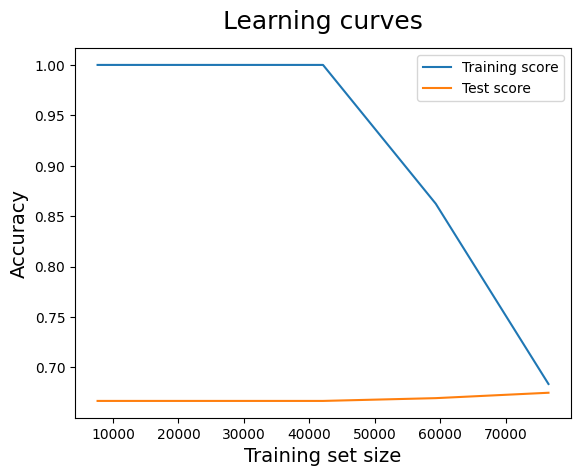

In [360]:
# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

## CatBoost

In [284]:
from catboost import CatBoostClassifier, Pool

In [285]:
X_train_cb, X_val_cb, y_train_cb, y_val_cb = train_test_split(X_train, y_train, test_size=0.2)

train_pool = Pool(data=X_train_cb, label=y_train_cb)
val_pool = Pool(data=X_val_cb, label=y_val_cb)

In [288]:
cboost = CatBoostClassifier(iterations=500,
                            learning_rate=0.1,
                            loss_function='Logloss',
                            eval_metric='Recall')

cboost.fit(train_pool, eval_set=val_pool)

0:	learn: 0.0186413	test: 0.0214655	best: 0.0214655 (0)	total: 22.8ms	remaining: 11.4s
1:	learn: 0.0181561	test: 0.0217883	best: 0.0217883 (1)	total: 30.8ms	remaining: 7.67s
2:	learn: 0.0277800	test: 0.0311491	best: 0.0311491 (2)	total: 42.5ms	remaining: 7.04s
3:	learn: 0.0262030	test: 0.0293738	best: 0.0311491 (2)	total: 52.1ms	remaining: 6.46s
4:	learn: 0.0240598	test: 0.0274371	best: 0.0311491 (2)	total: 58.8ms	remaining: 5.82s
5:	learn: 0.0333603	test: 0.0338928	best: 0.0338928 (5)	total: 67.4ms	remaining: 5.55s
6:	learn: 0.0302467	test: 0.0313105	best: 0.0338928 (5)	total: 76.3ms	remaining: 5.37s
7:	learn: 0.0308937	test: 0.0303422	best: 0.0338928 (5)	total: 85.7ms	remaining: 5.27s
8:	learn: 0.0306510	test: 0.0309877	best: 0.0338928 (5)	total: 95.5ms	remaining: 5.21s
9:	learn: 0.0360291	test: 0.0334087	best: 0.0338928 (5)	total: 104ms	remaining: 5.08s
10:	learn: 0.0375253	test: 0.0355068	best: 0.0355068 (10)	total: 111ms	remaining: 4.91s
11:	learn: 0.0424586	test: 0.0411556	best: 

In [289]:
y_pred = cboost.predict(X_test)

print("Accuracy =", accuracy_score(y_test, y_pred))
print("Recall =", recall_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))

Accuracy = 0.7039584032203958
Recall = 0.1283530645886408
Precision = 0.7034907597535934


## Random Forest Classifier

In [208]:
rdc = RandomForestClassifier(n_estimators=100, criterion="log_loss")
rdc.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss')

In [209]:
y_pred = rdc.predict(X_test)

print("Accuracy =", accuracy_score(y_test, y_pred))
print("Recall =", recall_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))

Accuracy = 0.6933195955336177
Recall = 0.10272740896148659
Precision = 0.6246013667425968


## SGDC Classifier

In [212]:
sgdc = SGDClassifier()
sgdc.fit(X_train, y_train)

SGDClassifier()

In [213]:
y_pred = sgdc.predict(X_test)

print("Accuracy =", accuracy_score(y_test, y_pred))
print("Recall =", recall_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))

Accuracy = 0.6802127761537355
Recall = 0.0
Precision = 0.0


/Users/jeremiesordoillet/.pyenv/versions/3.10.6/envs/mlb_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Deep learning

In [108]:
from tensorflow.keras import layers, Sequential

In [109]:
model_dl = Sequential([
    layers.Dense(5, activation="relu", input_dim=35),
    layers.Dense(5, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model_dl.compile(optimizer="adam",
              loss='binary_crossentropy', 
              metrics = 'accuracy')

history = model_dl.fit(X_train,
                       y_train,
                       batch_size=16,
                       epochs=100,
                       use_multiprocessing=True,
                       validation_split=0.2,
                       verbose=True)

Epoch 1/100
4869/4869 [==============================] - 3s 499us/step - loss: 0.6198 - accuracy: 0.6840 - val_loss: 0.6101 - val_accuracy: 0.6873
Epoch 2/100
4869/4869 [==============================] - 2s 457us/step - loss: 0.6059 - accuracy: 0.6906 - val_loss: 0.6051 - val_accuracy: 0.6914
Epoch 3/100
4869/4869 [==============================] - 2s 465us/step - loss: 0.6027 - accuracy: 0.6920 - val_loss: 0.6048 - val_accuracy: 0.6925
Epoch 4/100
4869/4869 [==============================] - 2s 462us/step - loss: 0.6021 - accuracy: 0.6918 - val_loss: 0.6051 - val_accuracy: 0.6928
Epoch 5/100
4869/4869 [==============================] - 2s 468us/step - loss: 0.6018 - accuracy: 0.6928 - val_loss: 0.6030 - val_accuracy: 0.6932
Epoch 6/100
4869/4869 [==============================] - 2s 456us/step - loss: 0.6015 - accuracy: 0.6920 - val_loss: 0.6032 - val_accuracy: 0.6929
Epoch 7/100
4869/4869 [==============================] - 2s 462us/step - loss: 0.6013 - accuracy: 0.6917 - val_loss: 0

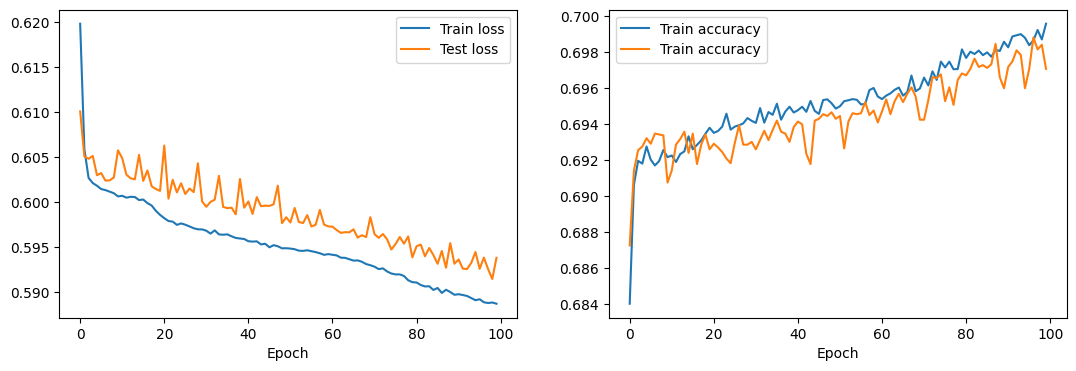

In [110]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))

ax1.plot(history.history['loss'], label="Train loss")
ax1.plot(history.history['val_loss'], label="Test loss")
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(history.history['accuracy'], label="Train accuracy")
ax2.plot(history.history['val_accuracy'], label="Test accuracy")
ax2.set_xlabel('Epoch')
ax2.legend()

In [111]:
y_pred = model_dl.predict(X_test)
y_pred

1305/1305 [==============================] - 0s 248us/step


array([[0.41992623],
       [0.24921474],
       [0.22991875],
       ...,
       [0.27609116],
       [0.2743203 ],
       [0.24061224]], dtype=float32)

In [112]:
y_pred = np.round(y_pred)

In [113]:
print("Accuracy =", accuracy_score(y_test, y_pred))
print("Recall =", recall_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))

Accuracy = 0.6914506158048593
Recall = 0.061490359562272015
Precision = 0.7536496350364964


## Try PCA before model

In [214]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=3)

pipe = make_pipeline(pca,
               GradientBoostingClassifier())
pipe

Pipeline(steps=[('pca', PCA(n_components=3)),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [215]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=3)),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [216]:
y_pred = pipe.predict(X_test)

In [217]:
accuracy_score(y_test, y_pred)

0.6799492020894234

In [218]:
pd.DataFrame(y_pred).value_counts()

0    41685
1       49
Name: count, dtype: int64

## XGBoost

In [300]:
from xgboost import XGBClassifier

model = XGBClassifier(
    objective='binary:logistic',  # Fonction d'objectif pour la classification binaire
    eval_metric='logloss',  # Métrique d'évaluation  # Profondeur maximale de l'arbre
    learning_rate=0.1,  # Taux d'apprentissage
    n_estimators=50  # Nombre d'arbres (itérations)
)

model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [301]:
y_pred = sgdc.predict(X_test)

print("Accuracy =", accuracy_score(y_test, y_pred))
print("Recall =", recall_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))

Accuracy = 0.6802127761537355
Recall = 0.0
Precision = 0.0


/Users/jeremiesordoillet/.pyenv/versions/3.10.6/envs/mlb_classification/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0    41734
Name: count, dtype: int64